In [1]:
import torch
import os
import sys
import copy
import numpy as np
import random

In [2]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [3]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]

':4096:8'

In [4]:
rand = 1
torch.manual_seed(rand)
torch.cuda.manual_seed(rand)
torch.cuda.manual_seed_all(rand)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(rand)
random.seed(rand)

In [5]:
torch.use_deterministic_algorithms(True)

In [6]:
import pandas as pd

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import networkx as nx

In [10]:
from torch_scatter import scatter_max, scatter_mean, scatter_min
from functools import lru_cache
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet

In [11]:
import wandb

In [12]:
device = "cuda:0"

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [15]:
from src.cv import crossvalidation, build_masks
from src.trainer import trainer
from src.cv import reset_model

In [16]:
import torch_geometric.transforms as T
transform = T.Compose([T.ToUndirected(), T.AddSelfLoops()])

In [17]:
results_dir = os.path.join('results','e8')
os.makedirs(results_dir, exist_ok=True)

config = {
    "custom_optimizer": torch.optim.Adam,
    "lr" : 0.01,
    'epochs': 100,
    'linear_layers': 2,
    'hidden_channels': 8,
    'dropout': 0.5,
    'test-percent': 15,
    'building_buffer': 200,
    'neighbor_radius': 100,
    'n_cv': 2,
    'cv_size': 600,
    'graph_outchannels': 2,
    'graph_layers':1,
    'graph_heads':1
}

In [18]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "w")
f.write(str("Config:\n"))
f.write(str(config))
f.close()

In [19]:
def pool_adjacency(graph, graph_auxillary):
    """Pools environmental features from the region for their use with regression"""
    # energy = scatter_mean(graph['footprint'].y, torch.tensor(graph_auxillary['rebuild_idx']).to(device))
    energy = graph['footprint'].y
    links = graph['footprint','contains','pano']['edge_index']
    features = scatter_mean(graph['pano'].x[links[1]], links[0], dim=0).detach().cpu().numpy()
    features_max = scatter_max(graph['pano'].x[links[1]], links[0], dim=0)[0].detach().cpu().numpy()
    features_min = scatter_min(graph['pano'].x[links[1]], links[0], dim=0)[0].detach().cpu().numpy()
    
    featurenames = graph_auxillary['node_data'].columns
    featuremin = featurenames + '_min'
    featuremax = featurenames + '_max'
    
    featuresdf = pd.DataFrame(graph['pano'].x.detach().cpu().numpy(), columns = featurenames)
    featuresdfmax = pd.DataFrame(features_max, columns = featuremax)
    featuresdfmin = pd.DataFrame(features_min, columns = featuremin)
    return graph_auxillary['footprints'].join(featuresdf).join(featuresdfmax).join(featuresdfmin)

In [20]:
from src.graph_construction import graph
g1, g1a = graph(
    "new-york",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)

g1p = pool_adjacency(g1, g1a)

In [21]:
g1a['normalization']

{'node': (tensor([3.2242e-02, 1.3131e-01, 3.9222e-03, 2.0727e-04, 1.5878e-03, 3.2282e-01,
          4.1924e-04, 3.5534e-03, 2.5414e-01, 1.9652e-03, 7.3342e-03, 8.2095e-05,
          2.2201e-03, 1.0210e-03, 6.6692e-02, 1.4664e-02, 2.3418e-04, 1.0276e-04,
          8.6611e-05, 1.5545e+01, 9.0298e-01, 5.1206e-01, 5.9186e+00, 8.7741e-01,
          7.5495e-01, 8.4074e-01, 1.0000e+00, 4.6954e-01, 9.7985e-01, 6.4949e-01,
          9.8925e-02, 6.7333e-01, 2.5265e-01, 2.3301e-01, 4.4374e-01, 1.7364e-01,
          1.5183e-01, 3.5595e-02], device='cuda:0'),
  tensor([2.5940e-02, 1.0261e-01, 1.4022e-02, 5.5618e-04, 3.1212e-03, 1.2948e-01,
          8.3298e-04, 1.5876e-02, 1.0432e-01, 9.1495e-03, 1.5451e-02, 4.7299e-04,
          1.7449e-03, 7.3549e-03, 9.6824e-02, 1.4938e-02, 8.6911e-04, 2.2184e-03,
          5.5918e-04, 7.4944e+00, 2.9603e-01, 1.0445e+00, 7.9103e+00, 3.2803e-01,
          4.3014e-01, 3.6595e-01, 3.1383e-03, 4.9907e-01, 1.4066e-01, 4.7715e-01,
          3.4939e-01, 9.8013e-01, 4.3

In [22]:
g2, g2a = graph(
    "san-francisco",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent'],
    normalization=g1a['normalization']
)

g2p = pool_adjacency(g2, g2a)

g3, g3a = graph(
    "austin",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent'],
    normalization=g1a['normalization']
)

g3p = pool_adjacency(g3, g3a)

<AxesSubplot: >

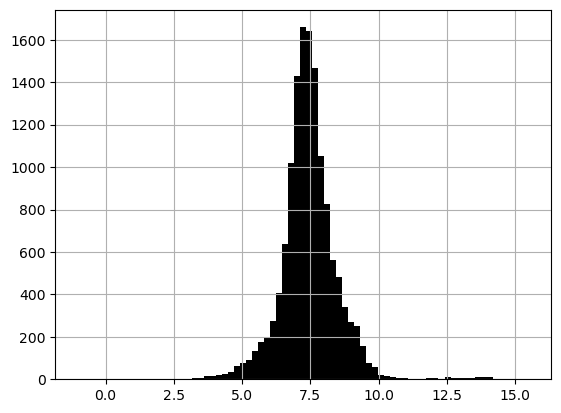

In [23]:
np.log(g1a['footprints'].energy).hist(bins=75, color="black")

In [24]:
g1p.drop(columns=["id","geometry","year"]).describe()

,energy,area,hdd,cdd,car_area,building_area,truck_area,traffic light_area,person_area,road_area,...,pole_count_min,vegetation_count_min,motorcycle_count_min,truck_count_min,terrain_count_min,rider_count_min,traffic light_count_min,wall_count_min,bus_count_min,train_count_min
count,1.363700e+04,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,...,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000
mean,9.376045e+03,9665.489353,2790.694836,4788.065835,0.133026,0.327735,0.090070,0.093213,0.254428,0.013445,...,-4.482502,-1.353637,-0.283134,-0.684591,-0.577519,-0.418763,-0.891777,-0.456653,-0.322349,-0.182869
std,1.213930e+05,8837.570781,566.430090,563.517667,1.012383,1.043205,1.156623,1.110930,1.159376,0.945887,...,3.389638,0.125404,0.000019,0.070941,0.094429,0.015395,0.051694,0.067797,0.040747,0.076668
min,3.597384e-01,27.870939,185.345664,2183.403795,-1.242973,-1.279698,-0.279712,-0.372666,-0.508716,-2.493125,...,-6.966121,-1.361168,-0.283134,-0.686985,-0.581400,-0.418895,-0.893105,-0.458396,-0.323129,-0.184006
25%,1.032021e+03,4157.322160,2493.654099,4425.396870,-0.724464,-0.434938,-0.279712,-0.372666,-0.415804,0.066478,...,-6.966121,-1.361168,-0.283134,-0.686985,-0.581400,-0.418895,-0.893105,-0.458396,-0.323129,-0.184006
50%,1.657017e+03,6530.718420,2922.010393,4792.428031,-0.032090,0.274551,-0.279712,-0.336706,-0.153089,0.304112,...,-6.966121,-1.361168,-0.283134,-0.686985,-0.581400,-0.418895,-0.893105,-0.458396,-0.323129,-0.184006
75%,2.843268e+03,11455.513336,3180.003893,5157.469268,0.801381,1.031112,-0.155625,-0.031050,0.458847,0.551786,...,0.143265,-1.361168,-0.283134,-0.686985,-0.581400,-0.418895,-0.893105,-0.458396,-0.323129,-0.184006
max,5.376747e+06,50304.071944,4149.092892,7351.370592,8.685810,3.924716,18.831144,15.737193,21.934244,1.387714,...,0.143265,0.734592,-0.283134,3.394125,1.719790,1.378841,1.119588,2.181500,1.805165,4.985416


In [25]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(g1p.drop(columns=["id","geometry","year"]).describe())

            energy      area       hdd       cdd  car_area  building_area  \
count    13,637.00 13,637.00 13,637.00 13,637.00 13,637.00      13,637.00   
mean      9,376.04  9,665.49  2,790.69  4,788.07      0.13           0.33   
std     121,393.02  8,837.57    566.43    563.52      1.01           1.04   
min           0.36     27.87    185.35  2,183.40     -1.24          -1.28   
25%       1,032.02  4,157.32  2,493.65  4,425.40     -0.72          -0.43   
50%       1,657.02  6,530.72  2,922.01  4,792.43     -0.03           0.27   
75%       2,843.27 11,455.51  3,180.00  5,157.47      0.80           1.03   
max   5,376,747.40 50,304.07  4,149.09  7,351.37      8.69           3.92   

       truck_area  traffic light_area  person_area  road_area  ...  \
count   13,637.00           13,637.00    13,637.00  13,637.00  ...   
mean         0.09                0.09         0.25       0.01  ...   
std          1.16                1.11         1.16       0.95  ...   
min         -0.28         

In [26]:
# from src.graph_construction import graph
# g1, g1a = graph(
#     "new-york",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )
# trainids, testids = build_corpus(g1, g1a)

# # nycgraph = transform(nycgraph)

In [27]:
idpool = g1a['footprints'].id
idtrain = idpool[g1a['training_mask'].detach().cpu().numpy()]
idtest = idpool[g1a['test_mask'].detach().cpu().numpy()]

### at this point, starting to train the model based on the new york data. m1 will be the linear model with no auxillary features, m2 will be the remote sensing data, m3 will be the comprehensive data

In [28]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
f.write(str("\n\n"))
f.write(str("NY Graph:\n"))
f.write(str(g1))
f.close()

In [29]:
from sklearn.model_selection import KFold

def build_corpus(graphobj, graphdata):
    trainids = []
    testids = []

    training_corpus = pool_adjacency(graphobj, graphdata).iloc[graphdata['training_mask'].detach().cpu().numpy()].reset_index(drop=True)

    kf = KFold(n_splits=config['n_cv'])
    for train, test in kf.split(training_corpus):
        trainids.append(training_corpus.id[train])
        testids.append(training_corpus.id[test])
        
    return trainids, testids

In [30]:
def custom_cv(model, training_corpus, trainids, testids):
    """This needs to implement cross validation but only using hte set which is found in the first radius search of the building"""
    losses = []
    abslosses = []
    for c,i in enumerate(trainids):
        custom_model = copy.deepcopy(model)
        training = training_corpus.loc[training_corpus.id.isin(i)]
        testing = training_corpus.loc[training_corpus.id.isin(testids[c])]
        
        X = np.array(training.drop(columns=["id","geometry","energy","year"]))
        y = np.array(training["energy"])
        custom_model.fit(X,y)
        
        Xt = np.array(testing.drop(columns=["id","geometry","energy","year"]))
        yt = np.array(testing["energy"])
        yhat = custom_model.predict(Xt)
        
        losses.append(np.power(((yhat - yt)**2).mean(axis=None), 0.5))
        abslosses.append(np.abs(yhat - yt).mean(axis=None))
        
    return (losses, abslosses)

In [31]:
# distances = np.linspace(config['building_buffer'], 1000, 10)

In [32]:
distances = np.logspace(np.log10(config['building_buffer']), np.log10(1000), 100)

In [33]:
# print(f"N Training: {len(trainids[0])}\nN Testing: {len(testids[0])}")

In [34]:
import matplotlib as mpl
mpl.rc('image', cmap='Set1')

In [35]:
import seaborn as sns
sns.set(style='ticks', palette='Dark2')

In [36]:
# print(f"Losses:\n\nM1: {m1_rmse:,.2f}\nM2: {m2_rmse:,.2f}\nM3: {m3_rmse:,.2f}")

In [37]:
# print(f"Losses:\n\nM4: {m4_rmse:,.2f}\nM5: {m5_rmse:,.2f}\nM6: {m6_rmse:,.2f}")

In [38]:
# np.mean(losses) / 1e6

In [39]:
# np.mean(abslosses)

In [40]:
# from src.graph_construction import graph
# sfgraph, sf_rebuild_info = graph(
#     "san-fransisco",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )

In [41]:
# f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
# f.write(str("\n\n"))
# f.write(str("San Fransisco Graph:\n"))
# f.write(str(sfgraph))
# f.close()

In [42]:
# from src.graph_construction import graph
# austingraph, austin_rebuild_info = graph(
#     "austin",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )

In [43]:
# f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
# f.write(str("\n\n"))
# f.write(str("Austin Graph:\n"))
# f.write(str(austingraph))
# f.close()

In [44]:
(~g1a['training_mask']).sum()

tensor(2045, device='cuda:0')

In [45]:
g1a['training_mask'].sum()

tensor(11592, device='cuda:0')

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
loss_func = torch.nn.MSELoss()

In [48]:
nyc_mask = g1a['training_mask'].cpu().numpy()

In [49]:
int(nyc_mask.sum() * 0.1)

1159

In [50]:
config['cv_size'] = int(nyc_mask.sum() * 0.1)
config['cv_size']

1159

In [51]:
config

{'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 100,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.5,
 'test-percent': 15,
 'building_buffer': 200,
 'neighbor_radius': 100,
 'n_cv': 2,
 'cv_size': 1159,
 'graph_outchannels': 2,
 'graph_layers': 1,
 'graph_heads': 1}

In [52]:
np.random.seed(1)
torch.manual_seed(1)
nyc_cvs = build_masks(
    nyc_mask, 
    n_cv = config['n_cv'],
    n_val = config['cv_size']
)

In [53]:
valmean = []
valstd = []

trainmean = []
trainstd = []

nyX = g1['footprint'].x.detach().cpu().numpy()
nyY = g1['footprint'].y.cpu()

cvtrain_errors = []
cv_errors = []
for crossfold in nyc_cvs:
    nytrain, nyval = crossfold

    linearmodel = ElasticNet()
    reg = linearmodel.fit(nyX[nytrain], nyY[nytrain])
    overfitpred = reg.predict(nyX[nytrain])
    fitpred = reg.predict(nyX[nyval])

    overfitloss = float(loss_func(torch.tensor(overfitpred), nyY[nytrain]))
    regloss = float(loss_func(torch.tensor(fitpred), nyY[nyval]))

    cvtrain_errors.append(overfitloss)
    cv_errors.append(regloss)

linear_regtrainerr = np.mean(cvtrain_errors)
linear_regerr = np.mean(cv_errors)

trainmean.append(linear_regtrainerr)
valmean.append(linear_regerr)

trainstd.append(np.std(cvtrain_errors))
valstd.append(np.std(cv_errors))

In [54]:
valmean

[0.9279444813728333]

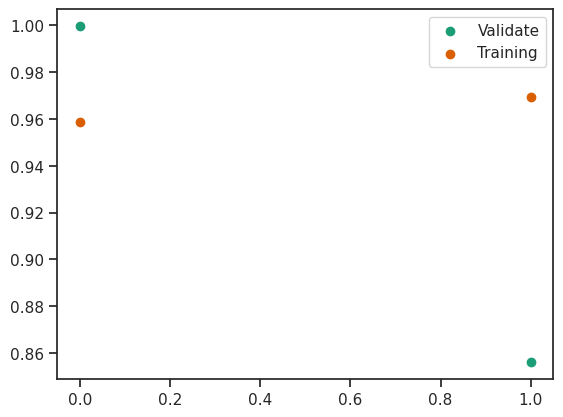

In [55]:
plt.scatter(range(len(cv_errors)), cv_errors, label="Validate")
plt.scatter(range(len(cvtrain_errors)), cvtrain_errors, label="Training")
plt.legend()

In [56]:
trainmean

[0.9640979170799255]

In [57]:
valmean

[0.9279444813728333]

In [58]:
linearmodel = ElasticNet()
fullreg = linearmodel.fit(nyX, nyY)

In [59]:
# plt.plot(range(ntesting), trainmean, label="training")
# plt.fill_between(
#     range(ntesting), 
#     np.array(trainmean) - np.array(trainstd), 
#     np.array(trainmean) + np.array(trainstd),
#     alpha=0.2
# ) 

# plt.plot(range(ntesting), valmean, label="validation")
# plt.fill_between(
#     range(ntesting), 
#     np.array(valmean) - np.array(valstd), 
#     np.array(valmean) + np.array(valstd),
#     alpha=0.2
# )

# plt.ylim(0.3, 1.3)
# plt.legend()
# plt.show()

In [60]:
config['epochs'] = int(1e3)
config['lr'] = 0.01

In [61]:
g1['footprint'].x

tensor([[-0.4593, -2.0581,  1.0214],
        [ 1.3625, -1.3477,  1.0551],
        [-1.3693, -2.1541,  1.3750],
        ...,
        [ 0.0688, -0.5793,  0.4599],
        [ 0.1639, -0.3993,  0.3117],
        [-1.5607,  0.3161,  0.7218]], device='cuda:0')

In [62]:
g1a['footprints'].drop(columns=["id","geometry","year"])

,energy,area,hdd,cdd
0,1022.022331,4982.209051,1624.918473,5363.637485
1,3524.173769,20209.961074,2027.315521,5382.643972
2,699.851991,2475.403896,1570.574722,5562.888029
3,799.409839,3261.550182,2155.821298,5101.226043
4,1440.605929,7022.361783,1592.129588,5359.351330
...,...,...,...,...
13632,1506.415508,5469.578870,3042.111339,4329.343815
13633,936.700677,4050.483561,2560.234039,4960.910782
13634,1777.684138,7476.843895,2462.567167,5047.228596
13635,1348.469953,8043.552987,2564.540412,4963.702072


In [63]:
g1a['node_data_original'].columns

Index(['pano_id', 'pano_date', 'geometry', 'id', 'car_area', 'building_area',
       'truck_area', 'traffic light_area', 'person_area', 'road_area',
       'traffic sign_area', 'terrain_area', 'sky_area', 'wall_area',
       'fence_area', 'motorcycle_area', 'pole_area', 'bus_area',
       'vegetation_area', 'sidewalk_area', 'bicycle_area', 'train_area',
       'rider_area', 'car_count', 'building_count', 'bicycle_count',
       'person_count', 'road_count', 'traffic sign_count', 'sidewalk_count',
       'sky_count', 'fence_count', 'pole_count', 'vegetation_count',
       'motorcycle_count', 'truck_count', 'terrain_count', 'rider_count',
       'traffic light_count', 'wall_count', 'bus_count', 'train_count'],
      dtype='object')

In [64]:
np.log(g1a['footprints'].energy)

0        6.929539
1        8.167401
2        6.550869
3        6.683874
4        7.272819
           ...   
13632    7.317488
13633    6.842364
13634    7.483067
13635    7.206726
13636    6.737796
Name: energy, Length: 13637, dtype: float64

In [65]:
config['input_shape'] = g1['footprint'].x.shape[1]

In [66]:
g1a['footprints']

,id,geometry,energy,area,year,hdd,cdd
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485
1,14406020392858049933,"POLYGON ((585796.868 4510668.833, 585753.012 4...",3524.173769,20209.961074,2012,2027.315521,5382.643972
2,4426560558493122672,"POLYGON ((585900.736 4510790.849, 585887.449 4...",699.851991,2475.403896,2017,1570.574722,5562.888029
3,10340616077727749642,"POLYGON ((586047.090 4510648.492, 586040.077 4...",799.409839,3261.550182,2017,2155.821298,5101.226043
4,12409346627080844976,"POLYGON ((585887.702 4510885.394, 585862.078 4...",1440.605929,7022.361783,2012,1592.129588,5359.351330
...,...,...,...,...,...,...,...
13632,6987024354454757481,"POLYGON ((596516.502 4507899.843, 596493.167 4...",1506.415508,5469.578870,2012,3042.111339,4329.343815
13633,4726222172377259971,"POLYGON ((596871.270 4507822.529, 596861.053 4...",936.700677,4050.483561,2017,2560.234039,4960.910782
13634,6711740151161711033,"POLYGON ((596911.794 4507718.461, 596864.772 4...",1777.684138,7476.843895,2016,2462.567167,5047.228596
13635,15462661130777948271,"POLYGON ((587553.484 4506394.824, 587545.199 4...",1348.469953,8043.552987,2012,2564.540412,4963.702072


In [67]:
from src.model import NullModel

# input_shape = nycgraph['footprint'].x.shape[1]
nullmodel = NullModel(
    layers = config['linear_layers'],
    input_shape = config['input_shape'],
    hidden_channels = config['hidden_channels']
).to(device)

default_nullmodelstate = copy.deepcopy(nullmodel.state_dict())
null_training_tensor, null_validation_tensor = crossvalidation(
    nullmodel,
    lambda: nullmodel(g1['footprint'].x),
    nyc_cvs,
    g1['footprint'].y,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

CV Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [68]:
null_validation_tensor.shape

(2, 1000)

In [69]:
from src.model import CustomGAT

model = CustomGAT(
    hidden_channels = config['hidden_channels'], 
    out_channels=config['graph_outchannels'],
    layers=config['graph_layers'],
    heads=config['graph_heads'],
    linear_layers = config['linear_layers'],
    input_shape = config['input_shape'],
    dropout = config['dropout']
).to(device)

default_modelstate = copy.deepcopy(model.state_dict())

/home/thomas/miniconda3/envs/dbr/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:58: UserWarning: There exist node types ({'pano'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


In [70]:
graph_training_tensor, graph_validation_tensor = crossvalidation(
    model,
    lambda: model(g1.x_dict, g1.edge_index_dict),
    nyc_cvs,
    g1['footprint'].y,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

CV Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [71]:
g1a['footprints'].describe()

,energy,area,year,hdd,cdd
count,1.363700e+04,13637.000000,13637.000000,13637.000000,13637.000000
mean,9.376045e+03,9665.489353,2014.139987,2790.694836,4788.065835
std,1.213930e+05,8837.570781,2.312740,566.430090,563.517667
min,3.597384e-01,27.870939,2012.000000,185.345664,2183.403795
25%,1.032021e+03,4157.322160,2012.000000,2493.654099,4425.396870
50%,1.657017e+03,6530.718420,2012.000000,2922.010393,4792.428031
75%,2.843268e+03,11455.513336,2017.000000,3180.003893,5157.469268
max,5.376747e+06,50304.071944,2017.000000,4149.092892,7351.370592


In [72]:
# g1a['footprints'].explore('energy', control_scale=True)

In [73]:
null_mean_tl = null_training_tensor.mean(axis=0)
null_mean_vl = null_validation_tensor.mean(axis=0)
nulllower_vl = np.percentile(null_validation_tensor, 5, axis=0)
nullupper_vl = np.percentile(null_validation_tensor, 95, axis=0)

In [74]:
mean_tl = graph_training_tensor.mean(axis=0)
std_tl = graph_training_tensor.std(axis=0)

mean_vl = graph_validation_tensor.mean(axis=0)
lower_vl = np.percentile(graph_validation_tensor, 5, axis=0)
upper_vl = np.percentile(graph_validation_tensor, 95, axis=0)
std_vl = graph_validation_tensor.std(axis=0)

# plt.plot(mean_tl, label="Graph Training")
# plt.plot(mean_vl, label="Graph Validation")
# plt.legend()

# plt.yscale("log")
# plt.ylim((0.55,0.65))

# plt.show()

In [75]:
mean_vl[:5]

array([22.827402, 21.671057, 20.24678 , 18.47567 , 16.384447],
      dtype=float32)

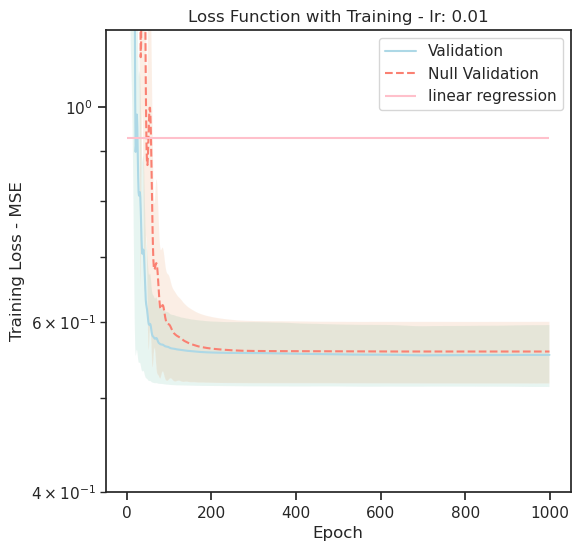

In [76]:
domain = np.arange(0, config['epochs'])
plt.figure(figsize=(6, 6), dpi=100)

# plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
plt.fill_between(domain, upper_vl, lower_vl, alpha=0.1)

# plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')
plt.fill_between(domain, nullupper_vl, nulllower_vl, alpha=0.1)

plt.hlines(valmean[0], min(domain), max(domain), color='pink', label="linear regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

plt.yscale("log")
plt.ylim((0.4,1.2))

plt.savefig(os.path.join(results_dir, 'model_comparison.png'), bbox_inches="tight")
plt.show()

In [ ]:
graph_improvement = (min(mean_vl) - min(null_mean_vl)) / min(null_mean_vl)
print("Improvement from Context: {:0.2f}%".format(100*graph_improvement))

In [ ]:
# now examining how this may generalize
model.eval()
nullmodel.eval()
with torch.no_grad():
    print("New York City")
    testidx = (~g1a['training_mask']).detach().cpu().numpy()
    # rebuilding_idx = np.array(g1a['rebuild_idx'])

    linear_predictions = reg.predict(g1['footprint'].x.cpu().numpy())[testidx]
    null_predictions = nullmodel(g1['footprint'].x).squeeze()[testidx]
    estimates = model(g1.x_dict, g1.edge_index_dict).squeeze().detach()[testidx]
    recorded = g1['footprint'].y[testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    
    print("Linear Loss:\t{:0.3f}".format(linear_loss))
    print("Null Loss:\t{:0.3f}".format(null_loss))
    print("Graph Loss:\t{:0.3f}".format(graph_loss))
    print("Improvement:\t{:0.3f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
linmae = torch.abs(torch.exp(recorded) - torch.tensor(np.exp(linear_predictions)).to(device))
nullmae = torch.abs(torch.exp(recorded) - torch.exp(null_predictions))
graphmae = torch.abs(torch.exp(recorded) - torch.exp(estimates))

In [ ]:
def relative_benefit(errors, threshold):
    count_pass = (errors <= threshold).sum()
    return float(100 * (count_pass / len(errors)))

In [ ]:
threshold = 100

print(f"Linear Benefit:\t\t{relative_benefit(linmae, threshold):0.2f}")
print(f"Null Benefit:\t\t{relative_benefit(nullmae, threshold):0.2f}")
print(f"Graph Benefit:\t\t{relative_benefit(graphmae, threshold):0.2f}")

In [ ]:
tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)
# tcorp

In [ ]:
## this is now the segment where we explore the utility of various datasets with increasing distance from the model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

m1a = []
m2a = []
m3a = []
m4a = []
m5a = []
m6a = []

m1l = []
m2l = []
m3l = []
m4l = []
m5l = []
m6l = []

linearmodel = ElasticNet()
tree = RandomForestRegressor(max_depth = 1, min_samples_leaf=10, n_estimators = 500, random_state = 1, n_jobs = -1)

# starting graph, which defines the test and train ids
g1, g1a = graph(
    "new-york",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)
trainids, testids = build_corpus(g1, g1a)

for distance in tqdm_notebook(distances):
    g1, g1a = graph(
        "new-york",
        neighbor_radius=config['neighbor_radius'],
        building_buffer=distance,
        test_percent=config['test-percent']
    )
    tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    m1a.append(m1_mae)
    m1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    m2a.append(m2_mae)
    m2l.append(m2_rmse)

    losses, abslosses = custom_cv(linearmodel, tcorp, trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    m3a.append(m3_mae)
    m3l.append(m3_rmse)

    m4_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(tree, tcorp[m4_terms], trainids, testids)
    m4_rmse = np.mean(losses)
    m4_mae = np.mean(abslosses)
    m4a.append(m4_mae)
    m4l.append(m4_rmse)

    m5_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losserandom_state, abslosses = custom_cv(tree, tcorp[m5_terms], trainids, testids)
    m5_rmse = np.mean(losses)
    m5_mae = np.mean(abslosses)
    m5a.append(m5_mae)
    m5l.append(m5_rmse)

    losses, abslosses = custom_cv(tree, tcorp, trainids, testids)
    m6_rmse = np.mean(losses)
    m6_mae = np.mean(abslosses)
    m6a.append(m6_mae)
    m6l.append(m6_rmse)

In [ ]:
n1a = []
n2a = []
n3a = []

n1l = []
n2l = []
n3l = []

# starting graph, which defines the test and train ids
g2, g2a = graph(
    "san-francisco",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)
trainids, testids = build_corpus(g2, g2a)

for distance in tqdm_notebook(distances):
    g2, g2a = graph(
        "san-francisco",
        neighbor_radius=config['neighbor_radius'],
        building_buffer=distance,
        test_percent=config['test-percent']
    )
    tcorp = pool_adjacency(g2, g2a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    n1a.append(m1_mae)
    n1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    n2a.append(m2_mae)
    n2l.append(m2_rmse)

    losses, abslosses = custom_cv(linearmodel, tcorp, trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    n3a.append(m3_mae)
    n3l.append(m3_rmse)

In [ ]:
o1a = []
o2a = []
o3a = []

o1l = []
o2l = []
o3l = []

# starting graph, which defines the test and train ids
g3, g3a = graph(
    "austin",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)
trainids, testids = build_corpus(g3, g3a)

for distance in tqdm_notebook(distances):
    g3, g3a = graph(
        "austin",
        neighbor_radius=config['neighbor_radius'],
        building_buffer=distance,
        test_percent=config['test-percent']
    )
    tcorp = pool_adjacency(g3, g3a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    o1a.append(m1_mae)
    o1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    o2a.append(m2_mae)
    o2l.append(m2_rmse)

    losses, abslosses = custom_cv(linearmodel, tcorp, trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    o3a.append(m3_mae)
    o3l.append(m3_rmse)

In [ ]:
import matplotlib as mpl
plt.style.use('fivethirtyeight')

In [ ]:
import scipy.optimize
def parabola(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

In [ ]:
fit_params, pcov = scipy.optimize.curve_fit(parabola, distances, m3l)

y_fit = parabola(distances, *fit_params)

In [ ]:
# plt.scatter(training_corpus
from csaps import csaps
from scipy.interpolate import splrep, BSpline

s = 0.0001
# m1s = splrep(distances, np.array(m1l), s=s)
# m2s = splrep(distances, np.array(m2l), s=s)
# m3s = splrep(distances, np.array(m3l), s=s)
# m4s = splrep(distances, np.array(m4l), s=s)
# m5s = splrep(distances, np.array(m5l), s=s)
# m6s = splrep(distances, np.array(m6l), s=s)
# Create subplots with shared x-axis

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(8,15))
fig.patch.set_facecolor('white')

ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')

# ax.set_color_cycle(sns.color_palette("coolwarm_r",6))

alpha = 0.2

# plt.scatter(distances, m4l, alpha=alpha)
# plt.scatter(distances, m5l, alpha=alpha)
# plt.scatter(distances, m6l, alpha=alpha)

newdist = np.linspace(distances[0], distances[-1], 300)
fit_params, pcov = scipy.optimize.curve_fit(parabola, distances, m3l)
m_fit = parabola(newdist, *fit_params)

nfit_params, pcov = scipy.optimize.curve_fit(parabola, distances, n3l)
n_fit = parabola(newdist, *nfit_params)

ofit_params, pcov = scipy.optimize.curve_fit(parabola, distances, o3l)
o_fit = parabola(newdist, *ofit_params)

ax1.set_title("Building Buffer vs. RMSE - New York City")
ax1.scatter(distances, m1l, alpha=0)
ax1.scatter(distances, m2l, alpha=0)
ax1.scatter(distances, m3l, alpha=alpha)

ax1.plot(newdist, csaps(distances, m1l, newdist, smooth=s), label="M1")
ax1.plot(newdist, csaps(distances, m2l, newdist, smooth=s), label="M2")
ax1.plot(newdist, m_fit, label="M3")

ax1.set_ylabel('RMSE')

ax2.scatter(distances, n1l, alpha=0)
ax2.scatter(distances, n2l, alpha=0)
ax2.scatter(distances, n3l, alpha=alpha)

ax2.plot(newdist, csaps(distances, n1l, newdist, smooth=s), label="M1")
ax2.plot(newdist, csaps(distances, n2l, newdist, smooth=s), label="M2")
ax2.plot(newdist, n_fit, label="M3")

ax2.set_ylabel('RMSE')

ax3.scatter(distances, o1l, alpha=0)
ax3.scatter(distances, o2l, alpha=0)
ax3.scatter(distances, o3l, alpha=alpha)

ax3.plot(newdist, csaps(distances, o1l, newdist, smooth=s), label="M1")
ax3.plot(newdist, csaps(distances, o2l, newdist, smooth=s), label="M2")
ax3.plot(newdist, o_fit, label="M3")

ax3.set_ylabel('RMSE')

# plt.plot(newdist, csaps(distances, m4l, newdist, smooth=s), label="M4")
# plt.plot(newdist, csaps(distances, m5l, newdist, smooth=s), label="M5")
# plt.plot(newdist, csaps(distances, m6l, newdist, smooth=s), label="M6")

ax3.set_xlabel("Building Buffer (m)")

# plt.title("Building Buffer vs. RMSE - New York City")
# plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.xticks(np.linspace(distances.min(), distances.max(), 8))

ax1.legend(loc="upper right")

ax1.set_title('New York City')
ax2.set_title('San Francisco')
ax3.set_title('Austin')

plt.savefig(os.path.join(results_dir, "contextual_significance.png"), transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5), dpi=400)
fig.patch.set_facecolor('white')

ax.set_facecolor('white')
# plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

# plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')

plt.hlines(valmean[0], min(domain), max(domain), color='pink', label="linear regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

plt.yscale("log")
plt.ylim((0.58,0.62))

plt.savefig(os.path.join(results_dir, 'model_comparison.png'), bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
# plt.scatter(training_corpus
from csaps import csaps
from scipy.interpolate import splrep, BSpline

s = 0.001
# m1s = splrep(distances, np.array(m1l), s=s)
# m2s = splrep(distances, np.array(m2l), s=s)
# m3s = splrep(distances, np.array(m3l), s=s)
# m4s = splrep(distances, np.array(m4l), s=s)
# m5s = splrep(distances, np.array(m5l), s=s)
# m6s = splrep(distances, np.array(m6l), s=s)

fig, ax = plt.subplots(figsize=(8,5), dpi=400)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# plt.yscale("log")

alpha = 0.2

# plt.scatter(distances, m1a, alpha=alpha)
# plt.scatter(distances, m2a, alpha=alpha)
# plt.scatter(distances, m3a, alpha=alpha)
plt.scatter(distances, m4a, alpha=alpha)
plt.scatter(distances, m5a, alpha=alpha)
plt.scatter(distances, m6a, alpha=alpha)

newdist = np.linspace(distances[0], distances[-1], 300)
# plt.plot(newdist, csaps(distances, m1a, newdist, smooth=s), label="M1")
# plt.plot(newdist, csaps(distances, m2a, newdist, smooth=s), label="M2")
# plt.plot(newdist, csaps(distances, m3a, newdist, smooth=s), label="M3")
plt.plot(newdist, csaps(distances, m4a, newdist, smooth=s), label="M4")
plt.plot(newdist, csaps(distances, m5a, newdist, smooth=s), label="M5")
plt.plot(newdist, csaps(distances, m6a, newdist, smooth=s), label="M6")

plt.ylabel("MAE")
plt.xlabel("Building Buffer (m)")

plt.title("Building Buffer vs. MAE - New York City")
plt.ticklabel_format(axis='y', style='sci', scilimits=(2,4))
plt.xticks(np.linspace(distances.min(), distances.max(), 8))

plt.legend(loc="upper right")
plt.savefig(os.path.join(results_dir, "contextual_significance_mae.png"))
plt.show()

In [ ]:
nycfootprints = g1a['footprints']
nycfootprints['logenergy'] = np.log(nycfootprints.energy)

# nycfootprints.explore('logenergy')

In [ ]:
torch.exp(null_predictions)

In [ ]:
testidx = (~g2a['training_mask']).detach().cpu().numpy()
testidx

In [ ]:
rebuilding_idx = np.array(g2a['rebuild_idx'])

In [ ]:
g1a['footprints']

In [ ]:
config

In [ ]:
g1, g1a = graph(
    "new-york",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)
g1a['footprints']['logenergy'] = np.log(g1a['footprints'].energy)

g1p = pool_adjacency(g1, g1a)

In [ ]:
## building these using generalization parameters from New York
g2, g2a = graph(
    "san-francisco",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent'],
    normalization=g1a['normalization']
)
g2a['footprints']['logenergy'] = np.log(g2a['footprints'].energy)
g2p = pool_adjacency(g2, g2a)

g3, g3a = graph(
    "austin",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent'],
    normalization=g1a['normalization']
)
g3a['footprints']['logenergy'] = np.log(g3a['footprints'].energy)
g3p = pool_adjacency(g3, g3a)

In [ ]:
g1a.keys()

In [ ]:
g1a['footprints'].logenergy

In [ ]:
g1a['footprints']

In [ ]:
config

In [ ]:
from tqdm import tqdm_notebook

## first want to load each of the models which will be trained on the entire dataset from the other city
nullmodel.load_state_dict(default_nullmodelstate)
nullmodel.to(device)
nullmodel.train()
    
model.load_state_dict(default_modelstate)
model.to(device)
model.train()

nulloptimizer = torch.optim.Adam(nullmodel.parameters(), lr = config['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])

# maybe I want to take the 5th percentile of minimum validation loss actually
set_epochs = config['epochs']

for epoch in tqdm_notebook(range(set_epochs), desc="Model Epoch", leave=False):
    loss = 0
    validation_loss = 0

    out = model(g1.x_dict, g1.edge_index_dict)
    out_ex = out.squeeze()

    training_predictions = out_ex.to(torch.float).to(device)
    training_values = torch.tensor(g1a['footprints'].logenergy).to(torch.float).to(device)

    loss = loss_func(
        training_predictions,
        training_values
    ).to(torch.float)
    
    if epoch % 100 == 0:
        print("{} loss: {}".format(epoch, loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("")
for epoch in tqdm_notebook(range(set_epochs), desc="NullModel Epoch", leave=False):
    loss = 0
    validation_loss = 0

    out = nullmodel(g1['footprint'].x)
    out_ex = out.squeeze()

    training_predictions = out_ex.to(torch.float).to(device)
    training_values = torch.tensor(g1a['footprints'].logenergy).to(torch.float).to(device)

    loss = loss_func(
        training_predictions,
        training_values
    ).to(torch.float)
    
    if epoch % 100 == 0:
        print("{} loss: {}".format(epoch, loss))

    nulloptimizer.zero_grad()
    loss.backward()
    nulloptimizer.step()
    
nystate_dict = model.state_dict()
nullnystate_dict = nullmodel.state_dict()

# training = training_corpus.loc[training_corpus.id.isin(i)]
# testing = training_corpus.loc[training_corpus.id.isin(testids[c])]

# X = np.array(training.drop(columns=["id","geometry","energy","year"]))
# y = np.array(training["energy"])
# custom_model.fit(X,y)

# Xt = np.array(testing.drop(columns=["id","geometry","energy","year"]))
# yt = np.array(testing["energy"])
# yhat = custom_model.predict(Xt)

In [ ]:
g2['footprint'].y

In [ ]:
# now examining how this may generalize
model.eval()
nullmodel.eval()

with torch.no_grad():
    print("San Fransisco")
    testidx = (~g2a['training_mask']).detach().cpu().numpy()
    rebuilding_idx = np.array(g2a['rebuild_idx'])
    null_predictions = nullmodel(g2['footprint'].x).squeeze()[testidx]
    
    linear_predictions = reg.predict(g2['footprint'].x.cpu().numpy())[testidx]
    estimates = model(g2.x_dict, g2.edge_index_dict).squeeze().detach()[testidx]
    recorded = g2['footprint'].y[testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
nullmodel.eval()
model.eval()
with torch.no_grad():
    print("Austin Texas")
    testidx = (~g3a['training_mask']).detach().cpu().numpy()
    rebuilding_idx = np.array(g3a['rebuild_idx'])
    null_predictions = nullmodel(g3['footprint'].x).squeeze()[testidx]
    
    linear_predictions = reg.predict(g3['footprint'].x.cpu().numpy())[testidx]
    
    estimates = model(g3.x_dict, g3.edge_index_dict).squeeze().detach()[testidx]
    recorded = g3['footprint'].y[testidx]
    
    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
optim = config['custom_optimizer']
optim(model.parameters())

In [ ]:
### I used the below cells to evaluate how many epochs to use for the final model

In [ ]:


# model.load_state_dict(default_modelstate)
# model.train()

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     model.to(device),
#     lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config
# )

# nystate_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# from src.trainer import trainer
# from src.cv import reset_model

# nullmodel.load_state_dict(default_nullmodelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     nullmodel.to(device),
#     lambda: nullmodel(nycgraph['footprint'].x),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config
# )

# nynull_state_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# plt.plot(trainlosses, label="training")
# plt.plot(testlosses, label="testing")

# plt.legend()
# plt.yscale("log")

# plt.show()

In [ ]:
# # this is manually set based on the above graph^
# from src.trainer import trainer

# model.load_state_dict(default_modelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# trainmask = np.repeat([True], len(trainmask))
# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     model.to(device),
#     lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config,
#     fulldata = True
# )

# nystate_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# nullmodel.train()
# nullmodel.load_state_dict(default_nullmodelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# trainmask = np.repeat([True], len(trainmask))
# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     nullmodel.to(device),
#     lambda: nullmodel(nycgraph['footprint'].x),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config,
#     fulldata = True
# )

# nystate_nulldict = copy.deepcopy(nystate_dict_origin)

In [ ]:
np.vstack((nyX, sfgraph['footprint'].x[:50].cpu().detach())).shape

In [ ]:
### this is going to be the drip system, to understand how slow incorporation of data changes the prediction quality

In [ ]:
nyY

In [ ]:
150 * 30 * 52 * 40 / 1e6

In [ ]:
# from tqdm import tqdm_notebook

# # now exploring how the model might generalize to SF
# sf_linearvalloss = []

# sf_valloss = []
# sf_nullvalloss = []

# config['epochs'] = 300

# for n_true in tqdm_notebook(range(100), leave=True):
#     model.load_state_dict(nystate_dict)
#     nullmodel.load_state_dict(nullnystate_dict)
    
#     model.train()
#     nullmodel.train()

#     sf_trainmask = copy.deepcopy(g2a['training_mask'])
#     sf_testmask = copy.deepcopy((~g2a['training_mask']))

#     sf_to_false = np.where(sf_trainmask.cpu().numpy())[0]
#     sf_to_false

#     np.random.seed(1)
#     drip_idx = np.random.choice(sf_to_false, n_true, replace=False)

#     # this now just drips in a bit of the sf data
#     sf_trainmask = np.repeat([False], len(sf_trainmask))
#     sf_trainmask[drip_idx] = True

#     rebuild_idx = np.array(g2a['rebuild_idx'])
    
#     # shapes
#     # print(f"trainmask shape: {trainmask.shape}")
    
#     ## building the linear model
#     x_linear_addition = np.vstack((nyX, g2['footprint'].x[sf_trainmask].cpu().detach()))
    
#     # print(f"Y shape: {nyY.shape}.")
#     # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
#     y_linear_addition = np.concatenate((nyY, g2['footprint'].y[sf_trainmask].cpu().detach()), axis=None)
    
#     reg = LinearRegression().fit(x_linear_addition, y_linear_addition)
#     preds = reg.predict(g2['footprint'].x[sf_testmask].cpu().detach())
#     existing_terms = g2['footprint'].y[sf_testmask].cpu().detach()
#     # print(f"Predictions: {preds}")
#     # print(f"Existing: {existing_terms}")
#     sf_linearvalloss.append(loss_func(torch.tensor(preds), existing_terms))

#     sf_state_dict, sf_trainlosses, sf_testlosses = trainer(
#         model.to(device),
#         lambda: model(g2.x_dict, g2.edge_index_dict),
#         rebuild_idx,
#         sf_trainmask,
#         sf_testmask,
#         recorded = g2['footprint'].y,
#         loss_func = loss_func,
#         config = config
#     )
    
#     _, _, sf_nulltestlosses = trainer(
#         nullmodel.to(device),
#         lambda: nullmodel(g2['footprint'].x),
#         rebuild_idx,
#         sf_trainmask,
#         sf_testmask,
#         recorded = g2['footprint'].y,
#         loss_func = loss_func,
#         config = config
#     )
#     sf_valloss.append(sf_testlosses)
#     sf_nullvalloss.append(sf_nulltestlosses)

In [ ]:
generalization_cv = 8
config['epochs'] = 300

In [ ]:
config['n_cv']

In [ ]:
from tqdm import tqdm_notebook

# now exploring how the model might generalize to SF
sf_linearvalloss = []
sf_valloss = []
sf_nullvalloss = []

for n_true in tqdm_notebook(range(100), leave=True):
    modelcv_loss = []
    nullmodelcv_loss = []
    linearcv_loss = []
    
    for cv in range(config['n_cv']):
        np.random.seed(cv)
        model.load_state_dict(nystate_dict)
        nullmodel.load_state_dict(nullnystate_dict)
        
        model.train()
        nullmodel.train()

        sf_trainmask = copy.deepcopy(g2a['training_mask'].cpu().numpy())
        np.random.shuffle(sf_trainmask)

        sf_testmask = ~sf_trainmask
        sf_to_false = np.where(sf_trainmask)[0]
        sf_to_false

        drip_idx = np.random.choice(sf_to_false, n_true, replace=False)

        # this now just drips in a bit of the sf data
        sf_trainmask = np.repeat([False], len(sf_trainmask))
        sf_trainmask[drip_idx] = True

        rebuild_idx = np.array(g2a['rebuild_idx'])

        # shapes
        # print(f"trainmask shape: {trainmask.shape}")

        ## building the linear model
        x_linear_addition = np.vstack((nyX, g2['footprint'].x[sf_trainmask].cpu().detach()))

        # print(f"Y shape: {nyY.shape}.")
        # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
        y_linear_addition = np.concatenate((nyY, g2['footprint'].y[sf_trainmask].cpu().detach()), axis=None)

        linearmodel = ElasticNet()
        reg = linearmodel.fit(x_linear_addition, y_linear_addition)
        preds = reg.predict(g2['footprint'].x[sf_testmask].cpu().detach())
        existing_terms = g2['footprint'].y[sf_testmask].cpu().detach()
        # print(f"Predictions: {preds}")
        # print(f"Existing: {existing_terms}")
        linearcv_loss.append(loss_func(torch.tensor(preds), existing_terms))

        sf_state_dict, sf_trainlosses, sf_testlosses = trainer(
            model.to(device),
            lambda: model(g2.x_dict, g2.edge_index_dict),
            rebuild_idx,
            sf_trainmask,
            sf_testmask,
            recorded = g2['footprint'].y,
            loss_func = loss_func,
            config = config
        )

        _, _, sf_nulltestlosses = trainer(
            nullmodel.to(device),
            lambda: nullmodel(g2['footprint'].x),
            rebuild_idx,
            sf_trainmask,
            sf_testmask,
            recorded = g2['footprint'].y,
            loss_func = loss_func,
            config = config
        )
        modelcv_loss.append(sf_testlosses)
        nullmodelcv_loss.append(sf_nulltestlosses)
        
    sf_linearvalloss.append(linearcv_loss)
    sf_valloss.append(modelcv_loss)
    sf_nullvalloss.append(nullmodelcv_loss)
        
sf_linearvalloss = np.array(sf_linearvalloss)
sf_valloss = np.array(sf_valloss)
sf_nullvalloss = np.array(sf_nullvalloss)

In [ ]:
np.percentile(sf_linearvalloss, 5, axis=1)

In [ ]:
np.arange(50)

In [ ]:
sf_linearvalloss.mean(axis=1)[-1]

In [ ]:
sf_nullvalloss.min(axis=2).mean(axis=1)[-1]

In [ ]:
sf_valloss.min(axis=2).mean(axis=1)[-1]

In [ ]:
1 - sf_valloss.min(axis=2).mean(axis=1)[-1] / sf_linearvalloss.mean(axis=1)[-1]

In [ ]:
1 - sf_valloss.min(axis=2).mean(axis=1)[-1] / sf_nullvalloss.min(axis=2).mean(axis=1)[-1]

In [ ]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(4, 6), dpi=600)

# plt.plot(sf_linearvalloss, label="Linear", color="coral")
# plt.plot(np.percentile(sf_nullvalloss, 5, axis=1), label="MLP", color="orange")
# plt.plot(np.percentile(sf_valloss, 2, axis=1), label="Graph", color="lightblue")
lower = 5
upper = 95

plt.plot(sf_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
plt.fill_between(
    np.arange(sf_linearvalloss.shape[0]), 
    np.percentile(sf_linearvalloss, lower, axis=1), 
    np.percentile(sf_linearvalloss, upper, axis=1), 
    color="firebrick", 
    alpha=0.1
)

plt.plot(sf_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(sf_nullvalloss.shape[0]), 
    np.percentile(sf_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(sf_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(sf_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(sf_valloss.shape[0]), 
    np.percentile(sf_valloss.min(axis=2), lower, axis=1), 
    np.percentile(sf_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend()
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to San Fransisco")
plt.xlabel("# Buildings from San Fransisco")
plt.ylabel("Loss - RMSE")

plt.ylim((0.5,1.5))

plt.savefig(os.path.join(results_dir, 'sf_generalization.png'), bbox_inches="tight")
plt.show()

In [ ]:
g3train = copy.deepcopy((g3a['training_mask']).cpu().numpy())
np.random.shuffle(g3train)

g3test = ~g3train

In [ ]:
from tqdm import tqdm_notebook

# now exploring how the model might generalize to SF
austin_linearvalloss = []
austin_valloss = []
austin_nullvalloss = []

for n_true in tqdm_notebook(range(100), leave=True):
    modelcv_loss = []
    nullmodelcv_loss = []
    linearcv_loss = []
    
    for cv in range(generalization_cv):
        np.random.seed(cv)
        model.load_state_dict(nystate_dict)
        nullmodel.load_state_dict(nullnystate_dict)
        
        model.train()
        nullmodel.train()

        austin_trainmask = copy.deepcopy(g3a['training_mask'].cpu().numpy())
        np.random.shuffle(austin_trainmask)

        austin_testmask = ~austin_trainmask
        austin_to_false = np.where(austin_trainmask)[0]
        austin_to_false

        drip_idx = np.random.choice(austin_to_false, n_true, replace=False)

        # this now just drips in a bit of the sf data
        austin_trainmask = np.repeat([False], len(austin_trainmask))
        austin_trainmask[drip_idx] = True

        rebuild_idx = np.array(g3a['rebuild_idx'])

        # shapes
        # print(f"trainmask shape: {trainmask.shape}")

        ## building the linear model
        x_linear_addition = np.vstack((nyX, g3['footprint'].x[austin_trainmask].cpu().detach()))

        # print(f"Y shape: {nyY.shape}.")
        # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
        y_linear_addition = np.concatenate((nyY, g3['footprint'].y[austin_trainmask].cpu().detach()), axis=None)

        linearmodel = ElasticNet()
        reg = linearmodel.fit(x_linear_addition, y_linear_addition)
        preds = reg.predict(g3['footprint'].x[austin_testmask].cpu().detach())
        existing_terms = g3['footprint'].y[austin_testmask].cpu().detach()
        # print(f"Predictions: {preds}")
        # print(f"Existing: {existing_terms}")
        linearcv_loss.append(loss_func(torch.tensor(preds), existing_terms))

        austin_state_dict, austin_trainlosses, austin_testlosses = trainer(
            model.to(device),
            lambda: model(g3.x_dict, g3.edge_index_dict),
            rebuild_idx,
            austin_trainmask,
            austin_testmask,
            recorded = g3['footprint'].y,
            loss_func = loss_func,
            config = config
        )

        _, _, austin_nulltestlosses = trainer(
            nullmodel.to(device),
            lambda: nullmodel(g3['footprint'].x),
            rebuild_idx,
            austin_trainmask,
            austin_testmask,
            recorded = g3['footprint'].y,
            loss_func = loss_func,
            config = config
        )
        modelcv_loss.append(austin_testlosses)
        nullmodelcv_loss.append(austin_nulltestlosses)
        
    austin_linearvalloss.append(linearcv_loss)
    austin_valloss.append(modelcv_loss)
    austin_nullvalloss.append(nullmodelcv_loss)
        
austin_linearvalloss = np.array(austin_linearvalloss)
austin_valloss = np.array(austin_valloss)
austin_nullvalloss = np.array(austin_nullvalloss)

In [ ]:
austin_valloss.mean(axis=1).min(axis=0).shape

In [ ]:
austin_nullvalloss.min(axis=2).shape

In [ ]:
austin_linearvalloss.mean(axis=1)[-5:]

In [ ]:
austin_nullvalloss.min(axis=2).mean(axis=1)[-5:]

In [ ]:
austin_valloss.min(axis=2).mean(axis=1)[-5:]

In [ ]:
1 - austin_valloss.min(axis=2).mean(axis=1)[-1] / austin_linearvalloss.mean(axis=1)[-1]

In [ ]:
1 - austin_valloss.min(axis=2).mean(axis=1)[-1] / austin_nullvalloss.min(axis=2).mean(axis=1)[-1]

In [ ]:
austin_linearvalloss.mean(axis=1)[0]

In [ ]:
austin_nullvalloss.min(axis=2).mean(axis=1)[0]

In [ ]:
austin_valloss.min(axis=2).mean(axis=1)[0]

In [ ]:
sampletable = [
    {"Linear":sf_linearvalloss.mean(axis=1)[-1], "MLP":sf_nullvalloss.min(axis=2).mean(axis=1)[-1], "Graph": sf_valloss.min(axis=2).mean(axis=1)[-1]},
    {"Linear":austin_linearvalloss.mean(axis=1)[-1], "MLP":austin_nullvalloss.min(axis=2).mean(axis=1)[-1], "Graph":austin_valloss.min(axis=2).mean(axis=1)[-1]}
]

tabledf = pd.DataFrame(sampletable, index=["San Francisco", "Austin"]).style.format(decimal='.', thousands=',', precision=2)
print(tabledf.to_latex())

In [ ]:
sampletable = [
    {"Linear":sf_linearvalloss.mean(axis=1)[0], "MLP":sf_nullvalloss.min(axis=2).mean(axis=1)[0], "Graph": sf_valloss.min(axis=2).mean(axis=1)[0]},
    {"Linear":austin_linearvalloss.mean(axis=1)[0], "MLP":austin_nullvalloss.min(axis=2).mean(axis=1)[0], "Graph":austin_valloss.min(axis=2).mean(axis=1)[0]}
]

tabledf = pd.DataFrame(sampletable, index=["San Francisco", "Austin"]).style.format(decimal='.', thousands=',', precision=2)
print(tabledf.to_latex())

In [ ]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(4, 6), dpi=600)

# plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
# plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
# plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")

plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
plt.fill_between(
    np.arange(austin_linearvalloss.shape[0]), 
    np.percentile(austin_linearvalloss, lower, axis=1), 
    np.percentile(austin_linearvalloss, upper, axis=1), 
    color="firebrick", 
    alpha=0.1
)

plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(austin_nullvalloss.shape[0]), 
    np.percentile(austin_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(austin_valloss.shape[0]), 
    np.percentile(austin_valloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend()
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to Austin")
plt.xlabel("# Buildings from Austin")
plt.ylabel("Loss - RMSE")

plt.ylim((0,0.3))
plt.savefig(os.path.join(results_dir, 'austin_generalization.png'), bbox_inches="tight")

plt.show()

In [ ]:
# ookaaay now I want to see how the model might generalize

In [ ]:
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))